<a href="https://colab.research.google.com/github/Irtisam99/CVPR/blob/main/MID/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/CVPR/mnist_model.keras"
model = load_model(model_path)


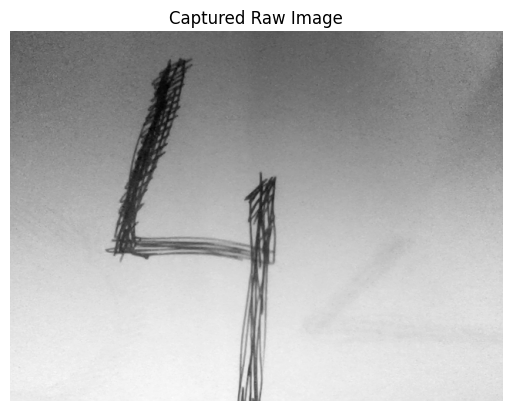

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipython-input-2971907870.py:92: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cy, cx = measurements.center_of_mass(img_padded)


Predicted Digit: 4  (Confidence: 74.64%)


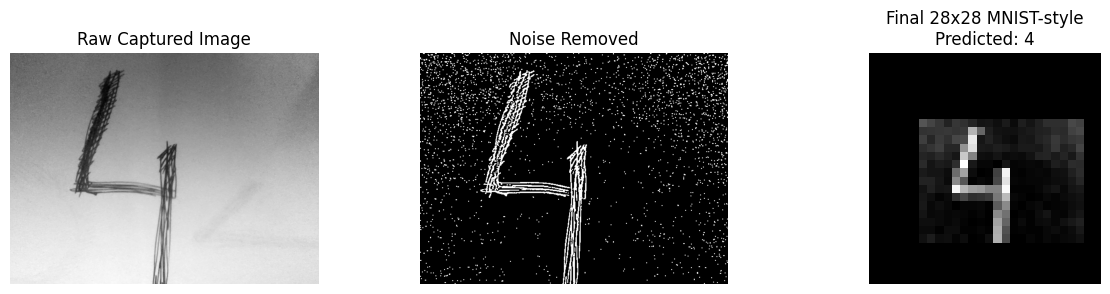

In [37]:
from google.colab import output
from base64 import b64decode
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements
from tensorflow.keras.models import load_model



#Step 1- Capture image from webcam
js = """
async function captureImage() {
  const div = document.createElement('div');
  const video = document.createElement('video');
  const button = document.createElement('button');
  button.textContent = 'Capture';
  div.appendChild(video);
  div.appendChild(button);
  document.body.appendChild(div);

  const stream = await navigator.mediaDevices.getUserMedia({video: true});
  video.srcObject = stream;
  await video.play();

  await new Promise((resolve) => button.onclick = resolve);

  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getVideoTracks()[0].stop();
  div.remove();
  return canvas.toDataURL('image/png');
}
captureImage();
"""
data = output.eval_js(js)
content = b64decode(data.split(',')[1])
with open('captured_digit.png', 'wb') as f:
    f.write(content)

#Step 2 Load as grayscale
img = cv2.imread('captured_digit.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.uint8)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Captured Raw Image")
plt.show()

# Preprocessing Function
def preprocess_mnist_style(img):
    # Step 1: Threshold + invert
    img_thresh = cv2.adaptiveThreshold(img, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV,
                                       11, 2)

    # Step 2: remove small noise
    kernel = np.ones((2,2), np.uint8)
    img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)

    # Step 3: Crop bounding box
    coords = cv2.findNonZero(img_thresh)
    if coords is None:
        raise ValueError("No digit detected. Try again with clearer input.")
    x, y, w, h = cv2.boundingRect(coords)
    img_crop = img_thresh[y:y+h, x:x+w]

    # Step 4: Resize to 20x20
    if w > h:
        scale = 20.0 / w
        new_w = 20
        new_h = int(h * scale)
    else:
        scale = 20.0 / h
        new_h = 20
        new_w = int(w * scale)

    img_resized = cv2.resize(img_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Step 5: Pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT, value=0)

    # Step 6: Center using center of mass
    cy, cx = measurements.center_of_mass(img_padded)
    rows, cols = img_padded.shape
    shiftx = np.round(cols/2 - cx).astype(int)
    shifty = np.round(rows/2 - cy).astype(int)
    M = np.float32([[1, 0, shiftx], [0, 1, shifty]])
    img_shifted = cv2.warpAffine(img_padded, M, (cols, rows), borderValue=0)

   # Flatten and normalize
    img_flat = img_shifted.astype('float32').reshape(1, 28*28) / 255.0

    return img_flat, img_thresh, img_shifted

# Step 3: Preprocess the captured digit
img_flat, img_thresh, img_final = preprocess_mnist_style(img)


pred = model.predict(img_flat)
digit = np.argmax(pred)
confidence = np.max(pred) * 100

print(f"Predicted Digit: {digit}  (Confidence: {confidence:.2f}%)")

#Step 5: Display intermediate and final images
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Raw Captured Image")

plt.subplot(1,3,2)
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.title("Noise Removed")

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.axis('off')
plt.title(f"Final 28x28 MNIST-style\nPredicted: {digit}")
plt.show()
